In [21]:
import os
import copy
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Transforms as T

### Global Variables:

In [23]:
random_seed = 0

#______/Image Initialization Data\________
dimension = 240
image_base = np.zeros((dimension, dimension))
base_labels = ['file_path', 'image_width', 'image_height',
               'center_x_ratio', 'center_y_ratio', 'num_rings']

center_x, center_y = int(dimension/2), int(dimension/2)
center_mask = image_base
center_mask[center_y, center_x] = 1

y, x = np.ogrid[0:dimension, 0:dimension]
circ_eq = (x - center_x)**2 + (y - center_y)**2
num_rings = 12
radii_labels = [f'radius_{i}' for i in range(1, num_rings + 1)]

min_ring_width = 0.001 * dimension
max_ring_width = 0.01 * dimension
radius_bound = 0.45 * dimension


#_______/Creation Function Inputs\_________
num_seed_images = 10
num_augments = 15
seed_pool = num_seed_images


#_________/Function Switches\_________
new_seeds = True
new_augments = True
save_npy = True
save_df = True

### Creation Functions

In [20]:
def create_seeds(num_seeds=num_seed_images, seed_label='Seed_Image', save_directory='Seed_Images', 
                 image_shape=(dimension, dimension), num_rings=num_rings, ring_variance=True):
    
    os.makedirs(save_directory, exist_ok=True)

    seed_data = []

    for index in range(1, num_seeds + 1):
        image_base = np.zeros((image_shape))

        if ring_variance:
            num_rings = random.randint(2, num_rings)

        radii_partials = np.cumsum(np.random.random(num_rings))

        min_radius = radii_partials[0]
        max_radius = radii_partials[-1]

        radii_exact = radii_partials / max_radius * radius_bound

        radii_keys = radii_labels[0:num_rings]
        radii_values = list(radii_partials[0:num_rings])
        
        for ring in range(0, num_rings):
            radius_outer = radii_exact[ring-1]
            radius_inner = radius_outer - random.uniform(min_ring_width, max_ring_width)

            mask_outer = circ_eq <= radius_outer**2
            mask_inner = circ_eq > radius_inner**2
            image_base[mask_outer & mask_inner] = 1
        
        save_path = os.path.join(save_directory, f'{seed_label}({index}).npy')

        if save_npy:
            np.save(save_path, image_base)

        base_keys = base_labels
        base_values = [save_path, dimension, dimension, 0.5, 0.5, num_rings]

        combined_keys = [*base_keys, *radii_keys]
        combined_values = [*base_values, *radii_values]

        seed_data.append({key: value for key, value in 
                          zip(combined_keys, combined_values)})
        
    seed_frame = pd.DataFrame(seed_data)

    if save_df:
        seed_frame.to_pickle('seed_frame.pickle')

    return None


def augment_seeds(num_augments=num_augments, augment_label='Augmented_Image', save_directory='Augmented_Images',
                  seed_pool=seed_pool, seed_data=None):
    
    os.makedirs(save_directory, exist_ok=True)
    transforms = [T.Random_Patch(max_num_patch=25), T.Random_Shift(), T.Random_Patch()]
    
    for i in range(seed_pool):
        seed_img = np.load(seed_data['file_path'][i])
        num_rings = seed_data['num_rings'][i]

        for j in range(num_augments):
            augment_path = os.path.join(save_directory, f'Seed_Image({i})-{augment_label}({j}).npy')
            augment_img = seed_img
            helper = copy.deepcopy(center_mask)
            
            for transform in transforms:
                augment_img, helper = transform(augment_img, helper)
            
            indices = np.where(helper==1)
            x, y, n = 0, 0, 0
            for coord in zip(*indices):
                x += coord[1]
                y += coord[0]
                n += 1

            x, y = x/n, y/n
            x_ratio, y_ratio = x/helper.shape[1], y/helper.shape[0]

            if save_npy:
                np.save(augment_path, augment_img)

            base_keys = base_labels
            base_values = [augment_path, dimension, dimension, x_ratio, y_ratio, num_rings]

NameError: name 'num_augments' is not defined

In [18]:
if new_seeds:
    create_seeds()

seed_frame = pd.read_pickle('seed_frame')


,file_path,image_width,image_height,center_x_ratio,center_y_ratio,radius_1,radius_2,radius_3,radius_4,radius_5,radius_6,radius_7,radius_8,radius_9,radius_10,radius_11
0,Seed_Images\Seed_Image(1).npy,240,240,0.5,0.5,0.578489,1.504600,2.480460,3.459774,4.398113,5.266553,6.066812,7.024566,7.659394,7.816168,7.825718
1,Seed_Images\Seed_Image(2).npy,240,240,0.5,0.5,0.335570,1.144509,2.019037,2.159742,2.312641,2.435159,3.238585,3.726338,4.710886,5.664498,6.532331
2,Seed_Images\Seed_Image(3).npy,240,240,0.5,0.5,0.371130,0.453678,1.135841,1.288413,1.980069,2.651719,2.902057,3.315787,3.401424,3.437454,NaN
3,Seed_Images\Seed_Image(4).npy,240,240,0.5,0.5,0.252847,0.423251,1.341218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Seed_Images\Seed_Image(5).npy,240,240,0.5,0.5,0.838777,1.003511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


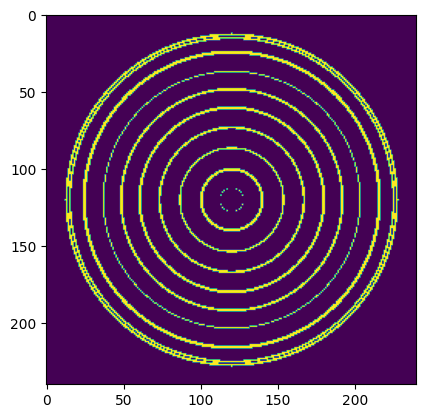

In [19]:
img = np.load(seed_frame['file_path'][0])
plt.imshow(img)
plt.show()